In [345]:
#Standard imports
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
from itertools import product

# Scikit Learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image

## DATA PREP

### Load and Split

In [329]:
# Load data
trainDataNP = np.load("fashion_train.npy")
testDataNP = np.load("fashion_test.npy")

# Split data into X and y arrays
X_train = trainDataNP[:, :-1]
y_train = trainDataNP[:, -1]
X_test = testDataNP[:, :-1]
y_test = testDataNP[:, -1]

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Transform to Tensor

In [330]:
# Define superclass to handle own input datasets
class CustomDataset(Dataset):
    def __init__(self, X, y, transform = None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):

        # Convert NumPy array to PIL Image
        image = Image.fromarray(self.X[idx])
        # image = Image.fromarray((self.X[idx] * 255).astype(np.uint8))  # Convert to [0, 255]

        # Collect image and label in sample dict
        sample = {'image': image, 'label': int(self.y[idx])}

        # Use transformer
        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

# Define transformer
transformer = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5], std = [0.5])
])

# # Create dataset
# train = CustomDataset(X_train_scaled, y_train, transform = transformer)

# # Define batch size
# batch_size = 64

# # Split train data into train and validation
# train, validation = torch.utils.data.random_split(train, [int(len(train) * .8), int(len(train) * .2)])

# # Create data loaders
# train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
# val_loader = DataLoader(validation, batch_size = batch_size, shuffle = True)

## CNN

### Build Model

In [382]:
# Create custom CNN model
# class CNN(nn.Module):
#     def __init__(self, n_classes, dropout_rate):
#         super(CNN, self).__init__()

#         # First convolutional layer: 1 input channel, 6 output channels, 5x5 kernel
#         self.conv1 = nn.Conv2d(1, 6, kernel_size = 5, padding = 2)
#         self.batchnorm1 = nn.BatchNorm2d(6) # Batch normalization
#         self.relu1 = nn.ReLU()
#         # self.batchnorm1 = nn.BatchNorm2d(6) # Batch normalization
#         self.pool1 = nn.AvgPool2d(kernel_size = 2, stride = 2)

#         # Second convolutional layer: 6 input channels, 16 output channels, 5x5 kernel
#         self.conv2 = nn.Conv2d(6, 16, kernel_size = 5)
#         self.batchnorm2 = nn.BatchNorm2d(16) # Batch normalization
#         self.relu2 = nn.ReLU()
#         # self.batchnorm2 = nn.BatchNorm2d(16)
#         self.pool2 = nn.AvgPool2d(kernel_size = 2, stride = 2)

#         # Fully connected layers
#         # Flatten before passing to fully connected layers
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.relu3 = nn.ReLU()
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(120, 84)
#         self.relu4 = nn.ReLU()
#         self.dropout2 = nn.Dropout(dropout_rate)
#         self.fc3 = nn.Linear(84, n_classes) # Output layer

#     def forward(self, x):

#         # First convolutional block
#         x = self.conv1(x)
#         x = self.batchnorm1(x)
#         x = self.relu1(x)
#         # x = self.batchnorm1(x)
#         x = self.pool1(x)

#         # Second convolutional block
#         x = self.conv2(x)
#         x = self.batchnorm2(x)
#         x = self.relu2(x)
#         # x = self.batchnorm2(x)
#         x = self.pool2(x)

#         # Flatten before passing to fully connected layers
#         x = x.reshape(x.size(0), -1)

#         # Fully connected layers
#         x = self.fc1(x)
#         x = self.relu3(x)
#         x = self.dropout1(x)
#         x = self.fc2(x)
#         x = self.relu4(x)
#         x = self.dropout2(x)
#         x = self.fc3(x)

#         return x

class CNN(nn.Module):
    def __init__(self, n_classes, activation_fn, dropout_rate):
        super(CNN, self).__init__()

        self.activation_fn = activation_fn

        # First convolutional block
        self.conv1_block = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.BatchNorm2d(6),
            self.activation_fn(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        # Second convolutional block
        self.conv2_block = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            self.activation_fn(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        # Fully connected layers
        self.fc_block = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            self.activation_fn(),
            nn.Dropout(dropout_rate),
            nn.Linear(120, 84),
            self.activation_fn(),
            nn.Dropout(dropout_rate),
            nn.Linear(84, n_classes)
        )

    def forward(self, x):
        print(x.size())
        # First convolutional block
        x = self.conv1_block(x)
        print(x.size())
        # Second convolutional block
        x = self.conv2_block(x)
        print(x.size())
        # Flatten before passing to fully connected layers
        x = x.reshape(x.size(0), -1)
        print(x.size())
        # Apply the fully connected layers
        x = self.fc_block(x)
        print(x.size())
        return x

### Instantiate Model

In [332]:
# # Define variables
# n_classes = len(np.unique(y_train))
# # alpha = .01 # .001 # Learning rate

# # Instantiate model
# model = CNN(n_classes = n_classes)

# # Set Loss function with criterion
# criterion = nn.CrossEntropyLoss()

# # Set optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr = alpha, weight_decay = 0.005, momentum = 0.9)  

# # Defnie total_step to ease iteration through batches
# total_step = len(train_loader)

### Train Model

In [383]:
# Define variables
n_epochs = 100 # Number of epochs to iterate
batch_size = 64
n_classes = len(np.unique(y_train))

# # Create device object to choose whether to run training on CPU or GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# if torch.backends.mps.is_available():
#     device = torch.device("mps")
# else:
#     device = torch.device('cpu')

# Define number of folds for cross-validation
n_folds = 2 # 5
kf = KFold(n_splits = n_folds, shuffle = True, random_state = 42)

# # Move model to the device
# model.to(device)

# Define lists to store training and validation metrics
train_losses = []
val_losses = []
val_accuracies = []

# Define variables for early stopping
early_stopping_patience = 7 # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_without_improvement = 0

# Define range of learning rates
learning_rates = [.001] # [.1, .01, .001, .0001]

# Define range of dropout rates
dropout_rates = [.3] # [.1, .2, .3, .4, .5, .6, .7, .8, .9]

# Dictionary to store performance metrics for each learning rate
lr_and_dr_performance = {}

#########################################
######### CROSS VALIDATION LOOP #########
#### Runs once for every combination ####
### of learning rate and dropout rate ###
#########################################

# Take cartesian product to iterate over each combination of learning rate and dropout rate
for learning_rate, dropout_rate in product(learning_rates, dropout_rates):
    print(f'\nLearning Rate: {learning_rate}, Dropout Rate: {dropout_rate}')

    # List to store validation accuracies for each fold
    val_accuracies = []

    # Iterate over cross-validation folds
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):

        #######################################
        ### INSTANTIATE MODEL FOR THIS FOLD ###
        #######################################

        # # Split data into training and validation sets for this fold
        # X_fold_train, y_fold_train = X_train_scaled[train_idx], y_train[train_idx]
        # X_fold_val, y_fold_val = X_train_scaled[val_idx], y_train[val_idx]

        # Split data into training and validation sets for this fold
        X_fold_train, y_fold_train = X_train[train_idx], y_train[train_idx]
        X_fold_val, y_fold_val = X_train[val_idx], y_train[val_idx]

        # Scale data
        scaler = StandardScaler()
        X_fold_train_scaled = scaler.fit_transform(X_fold_train)
        X_fold_val_scaled = scaler.transform(X_fold_val)

        # Create dataset and data loaders for this fold
        fold_train_dataset = CustomDataset(X_fold_train_scaled, y_fold_train, transform = transformer)
        fold_val_dataset = CustomDataset(X_fold_val_scaled, y_fold_val, transform = transformer)
        fold_train_loader = DataLoader(fold_train_dataset, batch_size = batch_size, shuffle = True)
        fold_val_loader = DataLoader(fold_val_dataset, batch_size = batch_size, shuffle = False)

        # Create a new model for each learning rate
        model = CNN(n_classes = n_classes, activation_fn = nn.Sigmoid, dropout_rate = dropout_rate).to(device)
        # optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay = .005, momentum = .9)
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #, weight_decay = .005)
        criterion = nn.CrossEntropyLoss()

        # Define schedular for early stopping
        schedular = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer = optimizer,
            patience = early_stopping_patience,
            verbose = True
        )

        # Define variables for early stopping
        best_val_loss = float('inf')
        epochs_without_improvement = 0

        ##########################################
        ### OUTER TRAINING AND VALIDATION LOOP ###
        ######## Runs once for each epoch ########
        ##########################################

        for epoch in range(n_epochs):
            model.train()
            running_loss = .0

            ###########################
            ### INNER TRAINING LOOP ###
            ###########################

            for batch in fold_train_loader:

                # Extract images and labels from the batch and move to device
                imgs, labels = batch['image'], batch['label']
                imgs, labels = imgs.to(device), labels.to(device)

                # Run model and collect loss
                optimizer.zero_grad()
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            # Calculate average training loss for the epoch
            train_loss = running_loss / len(fold_train_loader)
            train_losses.append(train_loss)

            ##############################
            ### INNER VALIDAITION LOOP ###
            ##############################

            model.eval()
            val_loss = .0
            correct = 0
            total = 0

            with torch.no_grad():
                for batch in fold_val_loader:

                    # Extract images and labels from the batch and move to device
                    imgs, labels = batch['image'], batch['label']
                    imgs, labels = imgs.to(device), labels.to(device)
                    
                    outputs = model(imgs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            # Calculate average validation loss and accuracy for the epoch
            val_loss /= len(fold_val_loader)
            val_losses.append(val_loss)
            val_accuracy = (correct/total) * 100
            # val_accuracies.append(val_accuracy)

            # Print training and validation statistics
            if (epoch + 1) % 5 == 0:
                print(f'Fold {fold + 1}/{n_folds}, ',
                    f'Epoch {epoch + 1}/{n_epochs}, ',
                    f'Train Loss: {train_loss:.4f}, ',
                    f'Val Loss: {val_loss:.4f}, ',
                    f'Val Accuracy: {val_accuracy:.2f}%')

            # # Print validation loss for each fold
            # print(f'Fold {fold + 1}, Epoch {epoch + 1}/{n_epochs}, Val Loss: {val_loss:.4f}')
            
            # Step the schedular based on the validation loss
            schedular.step(val_loss)

            # Check for early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= early_stopping_patience:
                print(f'Early stopping at epoch {epoch + 1} due to no improvement in validation loss.')
                break
                    
        # accuracy = correct / total
        # Append last validation accuracy for the fold to list of validation accuracies for learning rate
        val_accuracies.append(val_accuracy)

    # Calculate mean validation accuracy for this learning rate and dropout rate
    mean_val_accuracy = mean(val_accuracies)

    # Store the performance metric in the dictionary
    lr_and_dr_performance[(learning_rate, dropout_rate)] = mean_val_accuracy

    print(f'Mean Val Accuracy for Learning Rate {learning_rate} and Dropout Rate {dropout_rate}: {mean_val_accuracy:.4f}')

# Select the learning rate with the best performance
best_lr_and_dr = max(lr_and_dr_performance, key = lr_and_dr_performance.get)
print(f'\nBest Combination: \nLearning Rate: {best_lr_and_dr[0]}, Dropout Rate: {best_lr_and_dr[1]}, Mean Validation Accuracy: {lr_and_dr_performance[best_lr_and_dr]:.4f}')


Learning Rate: 0.001, Dropout Rate: 0.3
torch.Size([64, 1, 28, 28])
torch.Size([64, 6, 14, 14])
torch.Size([64, 16, 5, 5])
torch.Size([64, 400])
torch.Size([64, 5])
torch.Size([64, 1, 28, 28])
torch.Size([64, 6, 14, 14])
torch.Size([64, 16, 5, 5])
torch.Size([64, 400])
torch.Size([64, 5])
torch.Size([64, 1, 28, 28])
torch.Size([64, 6, 14, 14])
torch.Size([64, 16, 5, 5])
torch.Size([64, 400])
torch.Size([64, 5])
torch.Size([64, 1, 28, 28])
torch.Size([64, 6, 14, 14])
torch.Size([64, 16, 5, 5])
torch.Size([64, 400])
torch.Size([64, 5])
torch.Size([64, 1, 28, 28])
torch.Size([64, 6, 14, 14])
torch.Size([64, 16, 5, 5])
torch.Size([64, 400])
torch.Size([64, 5])
torch.Size([64, 1, 28, 28])
torch.Size([64, 6, 14, 14])
torch.Size([64, 16, 5, 5])
torch.Size([64, 400])
torch.Size([64, 5])
torch.Size([64, 1, 28, 28])
torch.Size([64, 6, 14, 14])
torch.Size([64, 16, 5, 5])
torch.Size([64, 400])
torch.Size([64, 5])
torch.Size([64, 1, 28, 28])
torch.Size([64, 6, 14, 14])
torch.Size([64, 16, 5, 5])
t

KeyboardInterrupt: 

In [351]:
# import itertools

# list1 = [1, 2, 3]
# list2 = ['a', 'b', 'c']

# for i, j in itertools.product(list1, list2):
#     print(i, j)

if (4 + 1) % 5 == 0:
    print(True)

True


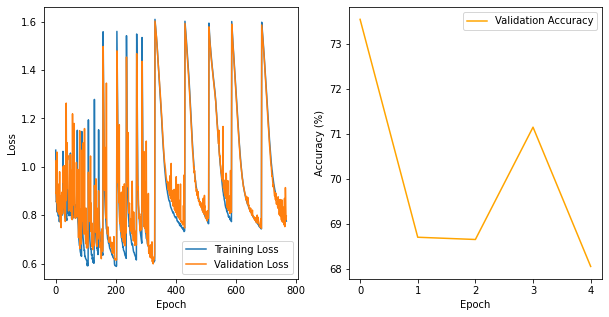

In [334]:
# Plot training curves
plt.figure(figsize = (10, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label = 'Training Loss')
plt.plot(val_losses, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label = 'Validation Accuracy', color = 'orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [335]:
# from lda import LDA
# MDA_4 = LDA(n_components = 4)

# X_projected_4 = MDA_4.fit_transform(X_train_scaled, y_train)
# X_t_projected_4 = MDA_4.transform(X_test_scaled)

In [336]:
# cnn = MLPClassifier()
# cnn.fit(X_projected_4, y_train)

In [337]:
# cnn.score(X_projected_4, y_train)

In [338]:
# y_pred = cnn.predict(X_t_projected_4)

# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy}')

In [339]:
# for n in range (1,10):
#     cnn = MLPClassifier()
#     scores = cross_val_score(cnn, X_train, y_train, cv=5)
#     print(n, round(np.mean(scores), 4), 'and', accuracy)